In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import time
import json
import argparse
import numpy as np
import cv2
import torch
import tensorflow as tf
from tensorflow.python.framework import graph_util
from easydict import EasyDict as edict
from yaml import load

import sys
sys.path.append('../data/')
sys.path.append('../model/')

from datasets import Human
from data_aug import Normalize_Img, Anti_Normalize_Img

from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt
import pylab
% matplotlib inline
plt.rcParams['figure.figsize'] = (5,5)

# from torchsummart import summary
# import onnxruntime
# from onnxruntime.datasets import get_example
# import onnx

# np.set_printoptions(threshold=np.inf)

In [2]:
def preprocess(img,fw ,fh, background, imgW, imgH, mean, std, ):
    
    background = cv2.resize(background, (fw, fh))

    # result_w, result_h=fw, fh

    # print("video is saved in " + videoOut)
    # video = cv2.VideoWriter(videoOut, cv2.VideoWriter_fourcc(*'mp4v'), 30, (result_w, result_h))
    
    # if not success or img is None:
    #     vidcap.release()
    #     break
    # img_orig = cv2.resize( img, (mid_w ,mid_h), interpolation=cv2.INTER_CUBIC)

    img_orig = np.copy(img)
    img = cv2.resize(img, (imgW, imgH),interpolation=cv2.INTER_CUBIC)

    img = img.astype(np.float32)
    for j in range(3):
        img[:, :, j] -= mean[j]
    for j in range(3):
        img[:, :, j] /= std[j]

    img /= 255
    img = img.transpose((2, 0, 1))
    img_tensor = torch.from_numpy(img)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # add a batch dimension
    return img_orig, background, img_tensor

def padding_img(img_ori, size=224, color=128):
    height = img_ori.shape[0]
    width = img_ori.shape[1]
    img = np.zeros((max(height, width), max(height, width), 3)) + color
    
    if (height > width):
        padding = int((height-width)/2)
        img[:, padding:padding+width, :] = img_ori
    else:
        padding = int((width-height)/2)
        img[padding:padding+height, :, :] = img_ori
        
    img = np.uint8(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
    return np.array(img, dtype=np.float32)

def resize_padding(image, dstshape, padValue=0):
    height, width, _ = image.shape
    ratio = float(width)/height # ratio = (width:height)
    dst_width = int(min(dstshape[1]*ratio, dstshape[0]))
    dst_height = int(min(dstshape[0]/ratio, dstshape[1]))
    origin = [int((dstshape[1] - dst_height)/2), int((dstshape[0] - dst_width)/2)]
    if len(image.shape)==3:
        image_resize = cv2.resize(image, (dst_width, dst_height))
        newimage = np.zeros(shape = (dstshape[1], dstshape[0], image.shape[2]), dtype = np.uint8) + padValue
        newimage[origin[0]:origin[0]+dst_height, origin[1]:origin[1]+dst_width, :] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    else:
        image_resize = cv2.resize(image, (dst_width, dst_height),  interpolation = cv2.INTER_NEAREST)
        newimage = np.zeros(shape = (dstshape[1], dstshape[0]), dtype = np.uint8)
        newimage[origin[0]:origin[0]+height, origin[1]:origin[1]+width] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    return newimage, bbx

def syn(img_out, img_orig, fw ,fh, background):
    # classMap_numpy = img_out[0].max(0)[1].byte().data.cpu().numpy()
    classMap_numpy = np.empty((224, 224), dtype=float)
    print(img_out[0].shape)
    print(img_out[0, :, :, 0])
    print("\n\n\n")
    print(img_out[0, :, :, 1])
    for i in range(224):
        for j in range(224):
            if img_out[0][i][j][1] > img_out[0][i][j][0]:
                classMap_numpy[i][j] = 255
            else:
                classMap_numpy[i][j] = 0

    # classMap_numpy = np.where(img_out[0] == np.max(img_out[0], axis=-1))[0]
    # print(classMap_numpy.shape)
    classMap_numpy=np.repeat(classMap_numpy[..., np.newaxis], 3, axis=2)
    idx_fg = cv2.resize(classMap_numpy, (fw, fh))
    cv2.imwrite("alpha.jpg", idx_fg)
    # print(img_orig.shape, idx_fg.shape, background.shape)
    # idx_fg = cv2.cvtColor(idx_fg, cv2.COLOR_GRAY2BGR)
    # seg_img=img_orig*idx_fg+background*(1-idx_fg)
    # return seg_img
    return None

def generate_input(exp_args, inputs, prior=None):
    inputs_norm = Normalize_Img(inputs, scale=exp_args.img_scale, mean=exp_args.img_mean, val=exp_args.img_val)
    
    if exp_args.video == True:
        if prior is None:
            prior = np.zeros((exp_args.input_height, exp_args.input_width, 1))
            inputs_norm = np.c_[inputs_norm, prior]
        else:
            prior = prior.reshape(exp_args.input_height, exp_args.input_width, 1)
            inputs_norm = np.c_[inputs_norm, prior]
       
    inputs = np.transpose(inputs_norm, (2, 0, 1))
    return np.array(inputs, dtype=np.float32)

def pred_single(model, exp_args, img_ori, prior=None):
    in_shape = img_ori.shape
#     img, bbx = resize_padding(img_ori, [exp_args.input_height, exp_args.input_width], padValue=exp_args.padding_color)
    image_resize = cv2.resize(img_ori, (224, 224))

#     in_ = generate_input(exp_args, img, prior)
    inputs_norm = Normalize_Img(image_resize, scale=exp_args.img_scale, mean=exp_args.img_mean, val=exp_args.img_val)
    in_ = inputs_norm[np.newaxis, :, :, :]
    
    with tf.Session() as sess:
        
        tf.global_variables_initializer().run()
        output_graph_def = tf.GraphDef()
        with open("../myTrain/Model/result.pb", "rb") as f:
            print("Loading pb")
            output_graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(output_graph_def, name="")
            
#         saver=tf.train.import_meta_graph("../myTrain/Model/result1950.meta")
#         saver.restore(sess, "../myTrain/Model/result1950")
        graph = tf.get_default_graph()
        x = graph.get_tensor_by_name('Inputs/x_input:0')
        y = graph.get_tensor_by_name('result:0')
        img_out = sess.run(y, feed_dict={x:in_})
    
    predimg = img_out[0,:,:,1]
#     out = predimg[bbx[1]:bbx[3], bbx[0]:bbx[2]]
    out = predimg
    out = cv2.resize(out, (in_shape[1], in_shape[0]))
    return out, predimg

def image_test(model, mean, std, image_name, background):
    
    image_path = image_name
    imgW, imgH = 224, 224
    
    img = cv2.imread("/home/yupeng/Program/python/Data/EG1800/Images/00001.png")
    fh ,fw=img.shape[:2]
    img_orig, background, img_tensor=preprocess(img, fw, fh, background, imgW, imgH, mean, std)
    stime=time.time()

    # with torch.no_grad():
    #     img_variable = torch.autograd.Variable(img_tensor)            
    #     img_out = model(img_variable)
    with tf.Session() as sess:
        input_x = img_tensor.cpu().detach().numpy()
        input_x = np.transpose(input_x, (0, 2, 3, 1))
        saver=tf.train.import_meta_graph("../myTrain/Model/result154.meta")
        saver.restore(sess, "../myTrain/Model/result154")
        graph = tf.get_default_graph()
        
        # writer = tf.summary.FileWriter("logs", graph)
        # writer.close()
        # for op in graph.get_operations():
        #     print(op.name)
        x = graph.get_tensor_by_name('Inputs/x_input:0')
        y = graph.get_tensor_by_name('Output/result:0')
        img_out = sess.run(y, feed_dict={x:input_x})
        
    etime=time.time()
    print("etime-stime:",etime-stime)
    
    result=syn(img_out,img_orig, fw, fh, background)
   

    # cv2.imwrite("result.jpg", result)


In [3]:
print ('===========> loading config <============')
config_path = '/home/yupeng/Program/python/PortraitNet/config/model_mobilenetv2_without_auxiliary_losses.yaml'
print ("config path: ", config_path)
with open(config_path, 'rb') as f:
    cont = f.read()
cf = load(cont)

exp_args = edict()

exp_args.istrain = cf['istrain']  # set the mode
exp_args.task = cf['task']  # only support 'seg' now
exp_args.datasetlist = cf['datasetlist']
exp_args.model_root = cf['model_root']
exp_args.data_root = cf['data_root']
exp_args.file_root = cf['file_root']

# the height of input images, default=224
exp_args.input_height = cf['input_height']
# the width of input images, default=224
exp_args.input_width = cf['input_width']

# if exp_args.video=True, add prior channel for input images, default=False
exp_args.video = cf['video']
# the probability to set empty prior channel, default=0.5
exp_args.prior_prob = cf['prior_prob']

# whether to add boundary auxiliary loss, default=False
exp_args.addEdge = cf['addEdge']
# the weight of boundary auxiliary loss, default=0.1
exp_args.edgeRatio = cf['edgeRatio']
# whether to add consistency constraint loss, default=False
exp_args.stability = cf['stability']
# whether to use KL loss in consistency constraint loss, default=True
exp_args.use_kl = cf['use_kl']
# temperature in consistency constraint loss, default=1
exp_args.temperature = cf['temperature']
# the weight of consistency constraint loss, default=2
exp_args.alpha = cf['alpha']

# input normalization parameters
exp_args.padding_color = cf['padding_color']
exp_args.img_scale = cf['img_scale']
# BGR order, image mean, default=[103.94, 116.78, 123.68]
exp_args.img_mean = cf['img_mean']
# BGR order, image val, default=[1/0.017, 1/0.017, 1/0.017]
exp_args.img_val = cf['img_val']

# whether to use pretian model to init portraitnet
exp_args.init = cf['init']
# whether to continue training
exp_args.resume = cf['resume']

# if exp_args.useUpsample==True, use nn.Upsample in decoder, else use nn.ConvTranspose2d
exp_args.useUpsample = cf['useUpsample']
# if exp_args.useDeconvGroup==True, set groups=input_channel in nn.ConvTranspose2d
exp_args.useDeconvGroup = cf['useDeconvGroup']

# img_ori = cv2.imread("/home/yupeng/Program/python/Data/EG1800/Images/00457.png")

import model_mobilenetv2_seg_small_tf as modellib
netmodel = modellib.MobileNetV2(n_class=2,
                                addEdge=exp_args.addEdge,
                                channelRatio=1.0,
                                minChannel=16)
print ("finish load PortraitNet ...")

# with tf.variable_scope('Inputs'):
#     x = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3], name='x_input')
#     y = tf.placeholder(dtype=tf.int64, shape=[None, 224, 224], name='y_input')

# pred = netmodel.build(x)

mean=[117.46679, 125.55083, 137.98093]
std=[63.793976, 63.89187,  65.8852  ]
# model , model_file,
# model.load_state_dict(torch.load(Max_name, "cpu"))# Load model
# model.eval()
# background = cv2.imread('syn_bg.jpg')
# image_test(netmodel, mean, std, image_name, background)
# netmodel.summary()

===========> loading config <============
('config path: ', '/home/yupeng/Program/python/PortraitNet/config/model_mobilenetv2_without_auxiliary_losses.yaml')
finish load PortraitNet ...


/home/yupeng/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


(800, 600)


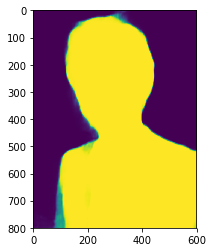

True

In [4]:
img_ori = cv2.imread("/home/yupeng/Program/python/Data/EG1800/Images/00001.png")

background = img_ori.copy()
background = cv2.blur(background, (17,17))

prior = None
height, width, _ = img_ori.shape

alphargb, pred = pred_single(netmodel, exp_args, img_ori, prior)
# print(alphargb)

print(alphargb.shape)

# maxnow = -1e9
# minnow = 1e9

# for i in range(alphargb.shape[0]):
#     for j in range(alphargb.shape[1]):
#         if alphargb[i][j] < minnow:
#             minnow = alphargb[i][j]
#         if alphargb[i][j] > maxnow:
#             maxnow = alphargb[i][j]

# print(minnow, maxnow)

# for i in range(800):
#     for j in range(600):
#         if ((alphargb[i][j] - minnow) / (maxnow - minnow) > 0.5):
#             alphargb[i][j] = 1
#         else:
#             alphargb[i][j] = 0

plt.imshow(alphargb)
plt.show()

alphargb = cv2.cvtColor(alphargb, cv2.COLOR_GRAY2BGR)
result = np.uint8(img_ori * alphargb + background * (1-alphargb))
cv2.imwrite("result.jpg", result)

### Background blur for single image

In [17]:
# img_ori = cv2.imread("/home/yupeng/Program/python/Data/EG1800/Images/00001.png")
# # mask_ori = cv2.imread("/home/yupeng/Program/python/Data/EG1800/Labels/00457.png")

# prior = None
# height, width, _ = img_ori.shape

# background = img_ori.copy()
# background = cv2.blur(background, (17,17))

# alphargb, pred = pred_single(netmodel_video, exp_args, img_ori, prior)
# # print(alphargb)
# plt.imshow(pred)
# plt.show()
# print alphargb.shape

# alphargb = cv2.cvtColor(alphargb, cv2.COLOR_GRAY2BGR)
# result = np.uint8(img_ori * alphargb + background * (1-alphargb))

# myImg = np.ones((height, width*2 + 20, 3)) * 255
# myImg[:, :width, :] = img_ori
# myImg[:, width+20:, :] = result

# plt.imshow(myImg[:,:,::-1]/255)
# plt.yticks([])
# plt.xticks([])
# plt.show()

### video test

In [6]:
# videofile = 'douyu_origin.mp4'
# videoCapture = cv2.VideoCapture(videofile)  
# size = ((int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH))+20)*3, int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))  
# videoWriter = cv2.VideoWriter('result.mp4', cv2.VideoWriter_fourcc(*'MJPG'), 20, size)  

# success, frame = videoCapture.read()
# cnt = 1
# while success:
#     if cnt == 1:
#         prior = None # first frame
#     else:
#         prior = pred_video
    
#     alpha_video, pred_video = pred_single(netmodel_video, exp_args, frame, prior)
#     alpha_image, pred_image = pred_single(netmodel_video, exp_args, frame, None)
    
#     def blend(frame, alpha):
#         background = np.zeros(frame.shape) + [255, 255, 255]
#         alphargb = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR)
#         result = np.uint8(frame * alphargb + background * (1-alphargb))
#         return frame, alphargb*255, result
    
#     _, alphargb_video, _ = blend(frame, alpha_video)
#     _, alphargb_image, _ = blend(frame, alpha_image)
    
#     padding = np.ones((frame.shape[0], 20, 3), dtype = np.uint8)*255
#     result = np.uint8(np.hstack((frame, padding,
#                                  alphargb_video, padding,
#                                  alphargb_image, padding)))
#     videoWriter.write(result)
#     success, frame = videoCapture.read()
#     cnt += 1
    
#     if cnt % 100 == 0:
#         print ("cnt: ", cnt)
    
# videoWriter.release()

# print "finish"

('cnt: ', 100)
('cnt: ', 200)
('cnt: ', 300)
('cnt: ', 400)
('cnt: ', 500)
('cnt: ', 600)
finish
